In [2]:
#install all the required dependancy libraries
!pip install tensorflow #for prediction
!pip install numpy  #for matrix multiplication
!pip install pandas #define the data structures
!pip install matplotlib #for visualization
!pip install scikit-learn #for normalizing our data(scaling)

#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline


In [3]:
#loading the dataset
from google.colab import files
uploaded = files.upload()

Saving btc.csv to btc.csv


In [4]:
#decoding the files as uploaded will be a dictionary of keys (the file names) and values (the encoded file objects)
btc = pd.read_csv(io.StringIO(uploaded['btc.csv'].decode('utf-8')))
btc.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,5/26/2018,BTCUSD,7459.11,7640.46,7380.00,7520.00,2722.80,2.042265e+07
1,5/25/2018,BTCUSD,7584.15,7661.85,7326.94,7459.11,8491.93,6.342069e+07
2,5/24/2018,BTCUSD,7505.00,7734.99,7269.00,7584.15,11033.72,8.293137e+07
3,5/23/2018,BTCUSD,7987.70,8030.00,7433.19,7505.00,14905.99,1.148104e+08
4,5/22/2018,BTCUSD,8393.44,8400.00,7950.00,7987.70,6589.43,5.389753e+07


In [5]:
#selecting only the column that we are going to use in the prediction process
data_to_use=btc['Close'].values
data_to_use

array([7520.  , 7459.11, 7584.15, ...,  378.  ,  378.  ,  370.  ])

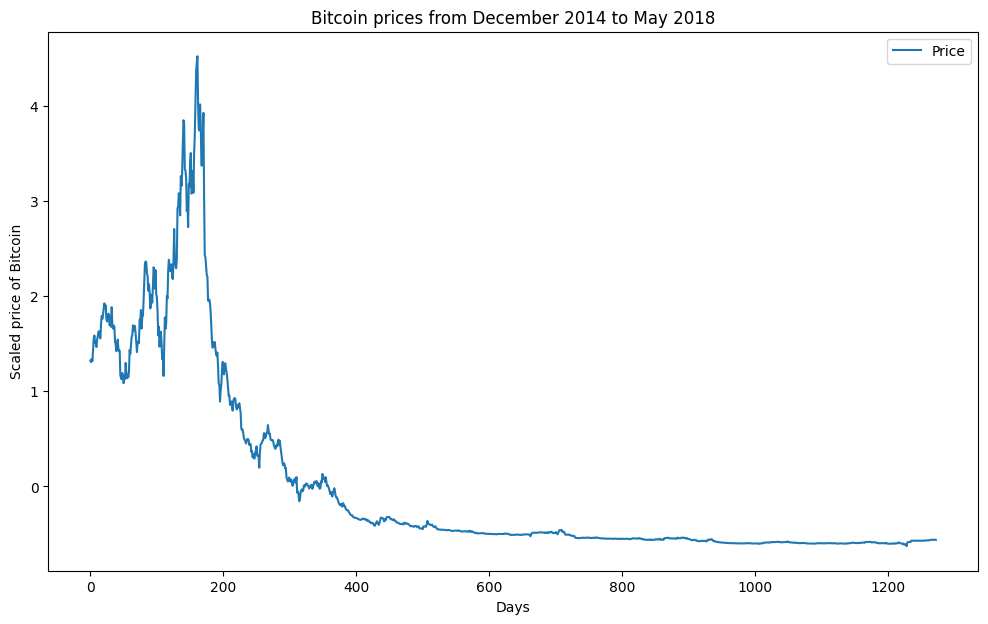

In [6]:
#data preprocessing(scaling)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 1))
#plotting the data
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled price of Bitcoin')
plt.plot(scaled_data, label='Price')
plt.legend()
plt.show()

In [7]:
# This function is used to create Features and Labels datasets. By windowing the data.
#Input: data - dataset used in the project
#window_size - how many data points we are going to use to predict the next datapoint in the sequence
#[Example: if window_size = 1 we are going to use only the previous day to predict todays stock prices]
#Outputs: X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1])
#y - 'labels', actually this is the next number in the sequence, this number we are trying to predict

def window_data(data, window_size):
    X = []
    y = []

    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])

        i += 1
    assert len(X) ==  len(y)
    return X, y
#windowing the data with window_data function
X, y = window_data(scaled_data, 7)


#we now split the data into training and test set
import numpy as np
X_train  = np.array(X[:1018])
y_train = np.array(y[:1018])

X_test = np.array(X[1018:])
y_test = np.array(y[1018:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 7, 1)
y_train size: (1018, 1)
X_test size: (248, 7, 1)
y_test size: (248, 1)


In [ ]:
#ate agora tudo foi copiado do link fornecido para rodar o projeto, agora vamos rodar esses primeiros hiperparametros e depois fazer nossos proprios testes
batch_size = 7
window_size = 7
hidden_layer = 256
clip_margin = 4
learning_rate = 0.001
epochs = 200

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

Instructions for updating:
non-resource variables are not supported in the long term


[<tf.Tensor 'add_63:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_127:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_191:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_255:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_319:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_383:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_447:0' shape=(1, 1) dtype=float32>]

In [ ]:
#we define the loss
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 30) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))


Epoch 0/200  Current loss: 0.28875723481178284
Epoch 30/200  Current loss: 0.05913089960813522
Epoch 60/200  Current loss: 0.01159659493714571
Epoch 90/200  Current loss: 0.010467746295034885
Epoch 120/200  Current loss: 0.007723554968833923
Epoch 150/200  Current loss: 0.006841229274868965
Epoch 180/200  Current loss: 0.00605869572609663


In [ ]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j][0])


tests = []
i = 0
while i+batch_size <= len(X_test):

    o = session.run([outputs],feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)



In [ ]:
tests_new = []
for i in range(len(tests)):
  for j in range(len(tests[i][0])):
    tests_new.append(tests[i][0][j])

In [ ]:

test_results = []
for i in range(1264):
    if i >= 1019:
      test_results.append(tests_new[i-1019])
    else:
      test_results.append(None)

ValueError: Input could not be cast to an at-least-1D NumPy array

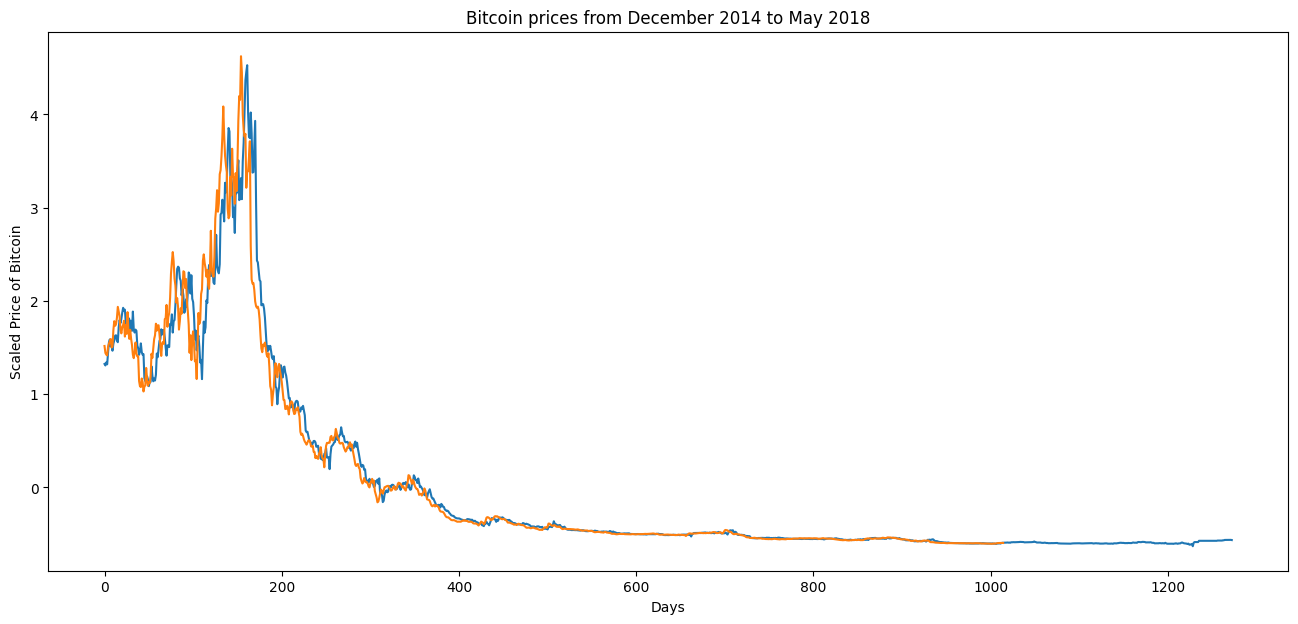

In [ ]:
#we now plot predictions from the network
plt.figure(figsize=(16, 7))
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()


In [ ]:
#iniciando sessao de testes, para retestar o modelo é necessário rodar novamente essa célula e a próxima com os novos parametros; teste 1

#diminuindo pela metade o número de hidden layers
batch_size = 7
window_size = 7
hidden_layer = 128
clip_margin = 4
learning_rate = 0.001
epochs = 200

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs


[<tf.Tensor 'add_511:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_575:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_639:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_703:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_767:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_831:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_895:0' shape=(1, 1) dtype=float32>]

In [ ]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 30) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.37595316767692566
Epoch 30/200  Current loss: 0.04107404500246048
Epoch 60/200  Current loss: 0.011039414443075657
Epoch 90/200  Current loss: 0.009560907259583473
Epoch 120/200  Current loss: 0.008033348247408867
Epoch 150/200  Current loss: 0.006691853981465101
Epoch 180/200  Current loss: 0.005934994202107191


Por reduzir apenas a quantidade de hidden layers, conseguimos chegar num resultado ainda melhor do que anteriormente, ou seja, poupamos processamento e ainda chegamos em um resultado melhor.


In [ ]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j][0])


tests = []
i = 0
while i+batch_size <= len(X_test):

    o = session.run([outputs],feed_dict={inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)

In [ ]:
tests_new = []
for i in range(len(tests)):
  for j in range(len(tests[i][0])):
    tests_new.append(tests[i][0][j])

In [ ]:

test_results = []
for i in range(1264):
    if i >= 1019:
      test_results.append(tests_new[i-1019])
    else:
      test_results.append(None)

ValueError: Input could not be cast to an at-least-1D NumPy array

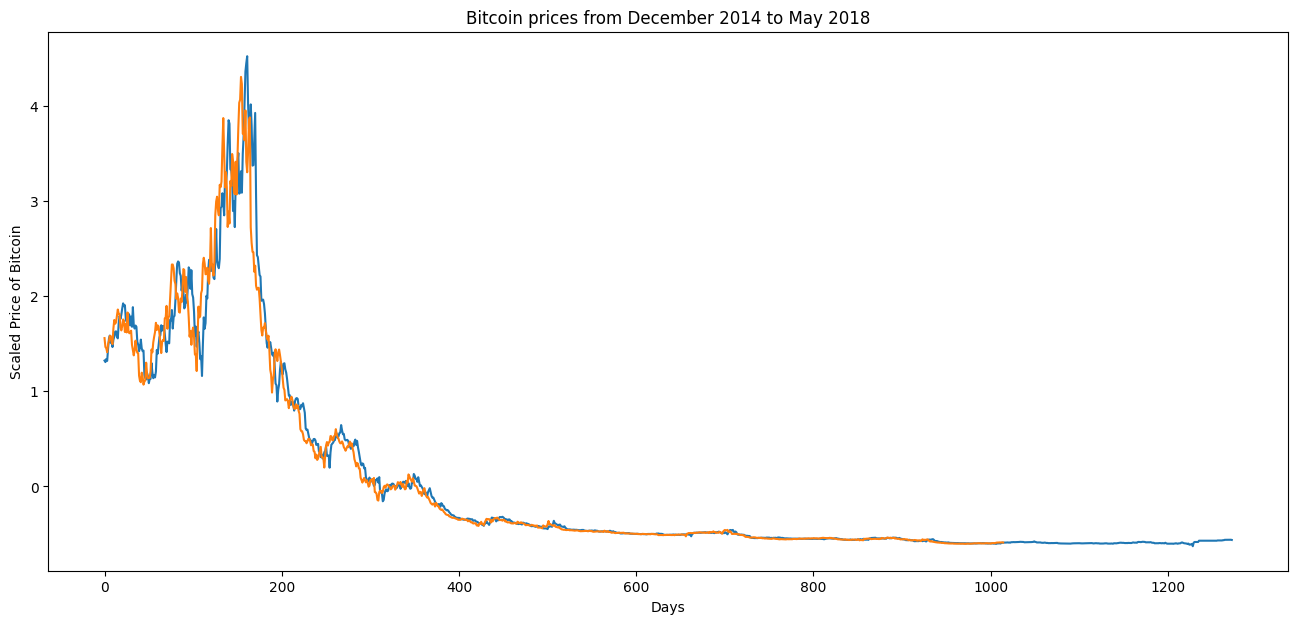

In [ ]:
#we now plot predictions from the network
plt.figure(figsize=(16, 7))
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled Price of Bitcoin')
plt.plot(scaled_data, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()


In [ ]:
#vamos tentar reduzir novamente o numero de hidden layers para ver se mantemos o desempenho ou se perdemos para achar o melhor número , teste 3
batch_size = 7
window_size = 7
hidden_layer = 64
clip_margin = 4
learning_rate = 0.001
epochs = 200

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs


[<tf.Tensor 'add_511:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_575:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_639:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_703:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_767:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_831:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_895:0' shape=(1, 1) dtype=float32>]

In [ ]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 20) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.7285171747207642
Epoch 20/200  Current loss: 0.05411476641893387
Epoch 40/200  Current loss: 0.022409193217754364
Epoch 60/200  Current loss: 0.012141343206167221
Epoch 80/200  Current loss: 0.00822270754724741
Epoch 100/200  Current loss: 0.007968599908053875
Epoch 120/200  Current loss: 0.007092914078384638
Epoch 140/200  Current loss: 0.006668785121291876
Epoch 160/200  Current loss: 0.006255833897739649
Epoch 180/200  Current loss: 0.0075666289776563644


Não conseguimos manter o desempenho reduzindo novamente o número de hidden layers, portanto vamos manter o número em 128 por enquanto


In [ ]:
#agora com o número de hidden layers 'definido' vamos tentar mudar os outros parametros, comecando pelo batch size, onde vamos tentar usar o tamanho de 16 -- teste 4
batch_size = 16
window_size = 7
hidden_layer = 128
clip_margin = 4
learning_rate = 0.001
epochs = 200

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs


[<tf.Tensor 'add_959:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1023:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1087:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1151:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1215:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1279:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1343:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1407:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1471:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1535:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1599:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1663:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1727:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1791:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1855:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1919:0' shape=(1, 1) dtype=float32>]

In [ ]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 20) == 0 or i==200:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.8260537981987
Epoch 20/200  Current loss: 0.04319222643971443
Epoch 40/200  Current loss: 0.02964189276099205
Epoch 60/200  Current loss: 0.016091015189886093
Epoch 80/200  Current loss: 0.00890293624252081
Epoch 100/200  Current loss: 0.015562673099339008
Epoch 120/200  Current loss: 0.007484846748411655
Epoch 140/200  Current loss: 0.007151931989938021
Epoch 160/200  Current loss: 0.007605182006955147
Epoch 180/200  Current loss: 0.009730782359838486


Após tentar aumentar o batch size, os resultados de perda foram ruins, não conseguindo chegar a uma loss miníma e variando muito, por isso tentaremos diminuir o tamanho do batch size.

In [ ]:
#agora com o número de hidden layers 'definido' vamos tentar mudar os outros parametros, comecando pelo batch size, onde vamos tentar usar o tamanho de 5 -- teste 5
batch_size = 5
window_size = 7
hidden_layer = 128
clip_margin = 4
learning_rate = 0.001
epochs = 200

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

[<tf.Tensor 'add_1983:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2047:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2111:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2175:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2239:0' shape=(1, 1) dtype=float32>]

In [ ]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 20) == 0 or i==199:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.29435527324676514
Epoch 20/200  Current loss: 0.04540400579571724
Epoch 40/200  Current loss: 0.01558215543627739
Epoch 60/200  Current loss: 0.009760619141161442
Epoch 80/200  Current loss: 0.008118699304759502
Epoch 100/200  Current loss: 0.0066260420717298985
Epoch 120/200  Current loss: 0.006298711057752371
Epoch 140/200  Current loss: 0.006306991912424564
Epoch 160/200  Current loss: 0.006017967592924833
Epoch 180/200  Current loss: 0.005164982285350561


Conseguimos melhorar o desempenho alcançando um novo melhor resultado, a partir de agora manteremos por enquanto o batch size em 5. Vale notar que a partir de agora vamos printar a epoca 199 que não estava sendo printada. Por isso, vou repetir o último teste para ter resultados verdadeiros.


In [ ]:
#agora com o número de hidden layers 'definido' vamos tentar mudar os outros parametros, comecando pelo batch size, onde vamos tentar usar o tamanho de 5 -- teste 6
batch_size = 5
window_size = 7
hidden_layer = 128
clip_margin = 4
learning_rate = 0.001
epochs = 200

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

[<tf.Tensor 'add_2303:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2367:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2431:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2495:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2559:0' shape=(1, 1) dtype=float32>]

In [ ]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 20) == 0 or i==199:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.28863516449928284
Epoch 20/200  Current loss: 0.03301073983311653
Epoch 40/200  Current loss: 0.01443031057715416
Epoch 60/200  Current loss: 0.010835405439138412
Epoch 80/200  Current loss: 0.00910954363644123
Epoch 100/200  Current loss: 0.007439804263412952
Epoch 120/200  Current loss: 0.006682157516479492
Epoch 140/200  Current loss: 0.00613526301458478
Epoch 160/200  Current loss: 0.0056292470544576645
Epoch 180/200  Current loss: 0.005797896068543196
Epoch 199/200  Current loss: 0.005728010553866625


Pronto, agora iremos tentar alterar a widowsize, começando diminuindo para 3 dias para conseguir prever pequenos ajustes nos preços

In [ ]:
#agora com o número de hidden layers 'definido' vamos tentar mudar os outros parametros, mudando widow size para 3 -- teste 7
batch_size = 5
window_size = 3
hidden_layer = 128
clip_margin = 4
learning_rate = 0.001
epochs = 200

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

[<tf.Tensor 'add_2587:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2615:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2643:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2671:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2699:0' shape=(1, 1) dtype=float32>]

In [ ]:
def window_data(data, window_size): #mudando o widow size para 3
    X = []
    y = []

    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])

        i += 1
    assert len(X) ==  len(y)
    return X, y
#windowing the data with window_data function
X, y = window_data(scaled_data, 3)


#we now split the data into training and test set
import numpy as np
X_train  = np.array(X[:1018])
y_train = np.array(y[:1018])

X_test = np.array(X[1018:])
y_test = np.array(y[1018:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 3, 1)
y_train size: (1018, 1)
X_test size: (252, 3, 1)
y_test size: (252, 1)


In [ ]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 20) == 0 or i==199:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.34375882148742676
Epoch 20/200  Current loss: 0.02954321913421154
Epoch 40/200  Current loss: 0.023292524740099907
Epoch 60/200  Current loss: 0.015191330574452877
Epoch 80/200  Current loss: 0.011132189072668552
Epoch 100/200  Current loss: 0.009063535369932652
Epoch 120/200  Current loss: 0.008203229866921902
Epoch 140/200  Current loss: 0.007874662056565285
Epoch 160/200  Current loss: 0.0075427088886499405
Epoch 180/200  Current loss: 0.007334374822676182
Epoch 199/200  Current loss: 0.0071278964169323444


Não obtivemos resultado bom diminuindo a widowsize, agora tentaremos aumenta-lá para 30 dias

In [ ]:
#mudando widow size para 30 -- teste 8
batch_size = 5
window_size = 30
hidden_layer = 128
clip_margin = 4
learning_rate = 0.001
epochs = 200

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

[<tf.Tensor 'add_2970:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_3241:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_3512:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_3783:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_4054:0' shape=(1, 1) dtype=float32>]

In [ ]:
def window_data(data, window_size): #mudando o widow size para 30
    X = []
    y = []

    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])

        i += 1
    assert len(X) ==  len(y)
    return X, y
#windowing the data with window_data function
X, y = window_data(scaled_data, 30)


#we now split the data into training and test set
import numpy as np
X_train  = np.array(X[:1018])
y_train = np.array(y[:1018])

X_test = np.array(X[1018:])
y_test = np.array(y[1018:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 30, 1)
y_train size: (1018, 1)
X_test size: (225, 30, 1)
y_test size: (225, 1)


In [ ]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 20) == 0 or i==199:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.416760116815567
Epoch 20/200  Current loss: 0.20618188381195068
Epoch 40/200  Current loss: 0.01672408916056156
Epoch 60/200  Current loss: 0.03689922019839287
Epoch 80/200  Current loss: 0.015921564772725105
Epoch 100/200  Current loss: 0.009797337464988232
Epoch 120/200  Current loss: 0.01157499197870493
Epoch 140/200  Current loss: 0.008211509324610233
Epoch 160/200  Current loss: 0.008687487803399563
Epoch 180/200  Current loss: 0.007675998844206333
Epoch 199/200  Current loss: 0.007532231509685516


O resultado não foi satisfatório. Apresentando grande varação entre as épocas e gerando um custo de processamento maior por levar em conta 30 dias, agora vamos testar com 14, caso o resultado também não seja satisfatório, voltaremos a 7

In [ ]:
# mudando widow size para 14 -- teste 9
batch_size = 5
window_size = 14
hidden_layer = 128
clip_margin = 4
learning_rate = 0.001
epochs = 200

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

[<tf.Tensor 'add_4181:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_4308:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_4435:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_4562:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_4689:0' shape=(1, 1) dtype=float32>]

In [ ]:
def window_data(data, window_size): #mudando o widow size para 14
    X = []
    y = []

    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])

        i += 1
    assert len(X) ==  len(y)
    return X, y
#windowing the data with window_data function
X, y = window_data(scaled_data, 14)


#we now split the data into training and test set
import numpy as np
X_train  = np.array(X[:1018])
y_train = np.array(y[:1018])

X_test = np.array(X[1018:])
y_test = np.array(y[1018:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 14, 1)
y_train size: (1018, 1)
X_test size: (241, 14, 1)
y_test size: (241, 1)


In [ ]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 20) == 0 or i==199:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.44188275933265686
Epoch 20/200  Current loss: 0.38765084743499756
Epoch 40/200  Current loss: 0.7747215032577515
Epoch 60/200  Current loss: 0.013700900599360466
Epoch 80/200  Current loss: 0.010259026661515236
Epoch 100/200  Current loss: 0.008715693838894367
Epoch 120/200  Current loss: 0.007492117118090391
Epoch 140/200  Current loss: 0.007684154435992241
Epoch 160/200  Current loss: 0.00716098677366972
Epoch 180/200  Current loss: 0.006164308171719313
Epoch 199/200  Current loss: 0.006595658138394356


O resultado também não foi dos melhores, iremos realizar um último teste na widow size, agora com valor de 5 para ver se obtemos alguma melhora, se não, seguiremos para outros parametros

In [ ]:
# mudando widow size para 5 -- teste 10
batch_size = 5
window_size = 5
hidden_layer = 128
clip_margin = 4
learning_rate = 0.001
epochs = 200

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

[<tf.Tensor 'add_4735:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_4781:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_4827:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_4873:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_4919:0' shape=(1, 1) dtype=float32>]

In [ ]:
def window_data(data, window_size): #mudando o widow size para 5
    X = []
    y = []

    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])

        i += 1
    assert len(X) ==  len(y)
    return X, y
#windowing the data with window_data function
X, y = window_data(scaled_data, 5)


#we now split the data into training and test set
import numpy as np
X_train  = np.array(X[:1018])
y_train = np.array(y[:1018])

X_test = np.array(X[1018:])
y_test = np.array(y[1018:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 5, 1)
y_train size: (1018, 1)
X_test size: (250, 5, 1)
y_test size: (250, 1)


In [ ]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 20) == 0 or i==199:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.24285578727722168
Epoch 20/200  Current loss: 0.04620243236422539
Epoch 40/200  Current loss: 0.02285032346844673
Epoch 60/200  Current loss: 0.012482931837439537
Epoch 80/200  Current loss: 0.009845415130257607
Epoch 100/200  Current loss: 0.008673902601003647
Epoch 120/200  Current loss: 0.00795407872647047
Epoch 140/200  Current loss: 0.007552572060376406
Epoch 160/200  Current loss: 0.007214440498501062
Epoch 180/200  Current loss: 0.006904201116412878
Epoch 199/200  Current loss: 0.006760466378182173


O resultado ainda foi inferior à widow size de 7, portanto vamos tomar ela como 7 mesmo. Vale notar que estamos presos em um current loss entre 0.005 e 0.006, vamos tentar mudar o learning rate e número de épocas agora


In [ ]:
# mudando learning rate para 0.0005 e 300 epocas -- teste 11
batch_size = 5
window_size = 7
hidden_layer = 128
clip_margin = 4
learning_rate = 0.0005
epochs = 300

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

[<tf.Tensor 'add_5213:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_5277:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_5341:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_5405:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_5469:0' shape=(1, 1) dtype=float32>]

In [ ]:
def window_data(data, window_size):
    X = []
    y = []

    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])

        i += 1
    assert len(X) ==  len(y)
    return X, y
#windowing the data with window_data function
X, y = window_data(scaled_data, 7)


#we now split the data into training and test set
import numpy as np
X_train  = np.array(X[:1018])
y_train = np.array(y[:1018])

X_test = np.array(X[1018:])
y_test = np.array(y[1018:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 7, 1)
y_train size: (1018, 1)
X_test size: (248, 7, 1)
y_test size: (248, 1)


In [ ]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 30) == 0 or i==299:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/300  Current loss: 0.575018048286438
Epoch 30/300  Current loss: 0.03449414297938347
Epoch 60/300  Current loss: 0.016268255189061165
Epoch 90/300  Current loss: 0.010464824736118317
Epoch 120/300  Current loss: 0.007275812793523073
Epoch 150/300  Current loss: 0.006670705042779446
Epoch 180/300  Current loss: 0.006188875529915094
Epoch 210/300  Current loss: 0.006314788479357958
Epoch 240/300  Current loss: 0.0051803989335894585
Epoch 270/300  Current loss: 0.0053329565562307835
Epoch 299/300  Current loss: 0.004499213770031929


Conseguimos um bom resultado, apesar de aumentar o custo computacional, conseguimos chegar em 0.004, vamos tentar abaixar o learning rate e aumentar as epocas mais uma vez para ver se conseguimos melhorar ainda mais

In [ ]:
# mudando learning rate para 0.0001 e 400 epocas -- teste 12
batch_size = 5
window_size = 7
hidden_layer = 128
clip_margin = 4
learning_rate = 0.0001
epochs = 400

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

[<tf.Tensor 'add_5533:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_5597:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_5661:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_5725:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_5789:0' shape=(1, 1) dtype=float32>]

In [ ]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 40) == 0 or i==399:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/400  Current loss: 1.0669338703155518
Epoch 40/400  Current loss: 0.034290362149477005
Epoch 80/400  Current loss: 0.02073126845061779
Epoch 120/400  Current loss: 0.01394751388579607
Epoch 160/400  Current loss: 0.010303928516805172
Epoch 200/400  Current loss: 0.008055229671299458
Epoch 240/400  Current loss: 0.007267606444656849
Epoch 280/400  Current loss: 0.006805751007050276
Epoch 320/400  Current loss: 0.0062682670541107655
Epoch 360/400  Current loss: 0.005984218325465918
Epoch 399/400  Current loss: 0.005733234342187643


a taxa de aprendizado de 0.0001 nao se provou boa, agora vamos tentar usar a de 0.0005

In [ ]:
# mudando learning rate para 0.0005 e 400 epocas -- teste 13
batch_size = 5
window_size = 7
hidden_layer = 128
clip_margin = 4
learning_rate = 0.0005
epochs = 400

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

Instructions for updating:
non-resource variables are not supported in the long term


[<tf.Tensor 'add_63:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_127:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_191:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_255:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_319:0' shape=(1, 1) dtype=float32>]

In [ ]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 40) == 0 or i==399:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/400  Current loss: 0.5720178484916687
Epoch 40/400  Current loss: 0.03304370492696762
Epoch 80/400  Current loss: 0.011326165869832039
Epoch 120/400  Current loss: 0.007650713436305523
Epoch 160/400  Current loss: 0.006719676777720451
Epoch 200/400  Current loss: 0.005778108723461628
Epoch 240/400  Current loss: 0.0053559476509690285
Epoch 280/400  Current loss: 0.005098922643810511
Epoch 320/400  Current loss: 0.004371023736894131
Epoch 360/400  Current loss: 0.0037951425183564425
Epoch 399/400  Current loss: 0.0040424894541502


Conseguimos um resultado bom na época 360 e depois regredimos, vamos tentar o mesmo exemplo mas agora com 500 épocas, caso não prove utilidade, tentaremos colocar épocas entre 300-400


In [ ]:
# mudando learning rate para 0.0005 e 500 epocas -- teste 14
batch_size = 5
window_size = 7
hidden_layer = 128
clip_margin = 4
learning_rate = 0.0005
epochs = 500

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

[<tf.Tensor 'add_383:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_447:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_511:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_575:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_639:0' shape=(1, 1) dtype=float32>]

In [ ]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 50) == 0 or i==499:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/500  Current loss: 0.5122868418693542
Epoch 50/500  Current loss: 0.016774121671915054
Epoch 100/500  Current loss: 0.007560082711279392
Epoch 150/500  Current loss: 0.0062993718311190605
Epoch 200/500  Current loss: 0.00566638121381402
Epoch 250/500  Current loss: 0.004904218018054962
Epoch 300/500  Current loss: 0.006049328949302435
Epoch 350/500  Current loss: 0.0052979509346187115
Epoch 400/500  Current loss: 0.004385064821690321
Epoch 450/500  Current loss: 0.00308659253641963
Epoch 499/500  Current loss: 0.003917569760233164


Depois de varias variações da loss nas épocas, na última bateria conseguimos atingir um valor recorde de 0.003, vamos tentar diminur o número de épocas e aumentar suavemente a learning rate, tentando buscar essa loss alcançada sem todas essas variações que aconteceram

---



In [7]:
# mudando learning rate para 0.001 e 300 epocas -- teste 15 -- teste meio aleatório, para tentar entender melhor como a learning rate e as epocas estão se comportando
batch_size = 5
window_size = 7
hidden_layer = 128
clip_margin = 4
learning_rate = 0.001
epochs = 300

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

Instructions for updating:
non-resource variables are not supported in the long term


[<tf.Tensor 'add_63:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_127:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_191:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_255:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_319:0' shape=(1, 1) dtype=float32>]

In [8]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 50) == 0 or i==299:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/300  Current loss: 0.2886889576911926
Epoch 50/300  Current loss: 0.011186820454895496
Epoch 100/300  Current loss: 0.0066604274325072765
Epoch 150/300  Current loss: 0.005322591867297888
Epoch 200/300  Current loss: 0.006463708356022835
Epoch 250/300  Current loss: 0.0058747255243361
Epoch 299/300  Current loss: 0.004366373643279076


Como esperado o resultado não foi bom, chegando ao final dos testes com a learning rate, tentaremos agora usar a de 0.0005 com 300 epócas, ja que ela foi a que conseguiu o melhor resultado e o único problema foi uma titubiância nas epócas finais

In [10]:
# mudando learning rate para 0.0005 e 300 epocas -- teste 16
batch_size = 5
window_size = 7
hidden_layer = 128
clip_margin = 4
learning_rate = 0.0005
epochs = 300

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

[<tf.Tensor 'add_703:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_767:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_831:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_895:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_959:0' shape=(1, 1) dtype=float32>]

In [11]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 50) == 0 or i==299:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/300  Current loss: 0.5519399642944336
Epoch 50/300  Current loss: 0.018847305327653885
Epoch 100/300  Current loss: 0.008729160763323307
Epoch 150/300  Current loss: 0.006603132467716932
Epoch 200/300  Current loss: 0.0059548974968492985
Epoch 250/300  Current loss: 0.0051090833730995655
Epoch 299/300  Current loss: 0.004254874773323536


Como observado anteriormente, a taxa de learning de 0.0005 demora mais a aprender, assim dificultando que em 300 épocas apresente resultado ótimo, como o nosso melhor resultado saiu na época 450/500 em uns testes atras, vamos tentar agora com 450 épocas. Também iremos arriscar uma mudança sutil na taxa, sendo agora 0.0004

In [12]:
# mudando learning rate para 0.0004 e 450 epocas -- teste 17
batch_size = 5
window_size = 7
hidden_layer = 128
clip_margin = 4
learning_rate = 0.0004
epochs = 450

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

[<tf.Tensor 'add_1023:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1087:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1151:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1215:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1279:0' shape=(1, 1) dtype=float32>]

In [14]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 50) == 0 or i==449:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/450  Current loss: 0.5755784511566162
Epoch 50/450  Current loss: 0.023520642891526222
Epoch 100/450  Current loss: 0.008287721313536167
Epoch 150/450  Current loss: 0.0066921706311404705
Epoch 200/450  Current loss: 0.0054135858081281185
Epoch 250/450  Current loss: 0.005166566930711269
Epoch 300/450  Current loss: 0.007015734910964966
Epoch 350/450  Current loss: 0.005491523537784815
Epoch 400/450  Current loss: 0.003928482532501221
Epoch 449/450  Current loss: 0.004131177440285683


In [8]:
# mudando learning rate para 0.0004 e 450 epocas -- teste 18 -- a taxa 0.0004 apresentou uma melhoria boa, vamos tentar aumentar as epócas
batch_size = 5
window_size = 7
hidden_layer = 128
clip_margin = 4
learning_rate = 0.0004
epochs = 500

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

[<tf.Tensor 'add_63:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_127:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_191:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_255:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_319:0' shape=(1, 1) dtype=float32>]

In [9]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 50) == 0 or i==499:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/500  Current loss: 0.653827965259552
Epoch 50/500  Current loss: 0.020835066214203835
Epoch 100/500  Current loss: 0.009289778769016266
Epoch 150/500  Current loss: 0.006752738729119301
Epoch 200/500  Current loss: 0.005416069179773331
Epoch 250/500  Current loss: 0.009895590133965015
Epoch 300/500  Current loss: 0.005158011335879564
Epoch 350/500  Current loss: 0.0062384153716266155
Epoch 400/500  Current loss: 0.003877679817378521
Epoch 450/500  Current loss: 0.0036585743073374033
Epoch 499/500  Current loss: 0.003913811407983303


Para finalizar os testes de learning rate, tentaremos 0.0005 com 450 epocas


In [12]:
# mudando learning rate para 0.0005 e 450 epocas -- teste 19 -- a taxa 0.0004 apresentou uma melhoria boa, vamos tentar aumentar as epócas
batch_size = 5
window_size = 7
hidden_layer = 128
clip_margin = 4
learning_rate = 0.0005
epochs = 450

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

[<tf.Tensor 'add_703:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_767:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_831:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_895:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_959:0' shape=(1, 1) dtype=float32>]

In [13]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 50) == 0 or i==449:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/450  Current loss: 0.5008678436279297
Epoch 50/450  Current loss: 0.014897557906806469
Epoch 100/450  Current loss: 0.008341250009834766
Epoch 150/450  Current loss: 0.006426945794373751
Epoch 200/450  Current loss: 0.006201307289302349
Epoch 250/450  Current loss: 0.005719465669244528
Epoch 300/450  Current loss: 0.004994014743715525
Epoch 350/450  Current loss: 0.005072608590126038
Epoch 400/450  Current loss: 0.00455183582380414
Epoch 449/450  Current loss: 0.004369713831692934


O resultado não foi satisfatório. Manteremos 0.0005 e 500 epocas

In [19]:
# mudando learning rate para 0.0005 e 500 epocas -- teste 20 --- teste final com learning rate e epocas
batch_size = 5
window_size = 7
hidden_layer = 128
clip_margin = 4
learning_rate = 0.0005
epochs = 500

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

[<tf.Tensor 'add_1663:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1727:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1791:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1855:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_1919:0' shape=(1, 1) dtype=float32>]

In [20]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 50) == 0 or i==499:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/500  Current loss: 0.5300008654594421
Epoch 50/500  Current loss: 0.023650888353586197
Epoch 100/500  Current loss: 0.008700547739863396
Epoch 150/500  Current loss: 0.006697542034089565
Epoch 200/500  Current loss: 0.0057250033132731915
Epoch 250/500  Current loss: 0.005867592059075832
Epoch 300/500  Current loss: 0.0051478492096066475
Epoch 350/500  Current loss: 0.00461102370172739
Epoch 400/500  Current loss: 0.004700975026935339
Epoch 450/500  Current loss: 0.002713216235861182
Epoch 499/500  Current loss: 0.003313068998977542


Vamos finalizar nesses parametros de learning rate e epocas, pois a rede neural está alterando entre épocas, mas nessa configuração foi o melhor resultado que conseguimos, 0.0027. Agora vamos tentar diminuir o clip-margin para evitar explosão de gradientes e depois testar um aumento nas hidden layers para ver se nessa nova configuração faz efeito

In [21]:
# clip margin 3 -- teste 21
batch_size = 5
window_size = 7
hidden_layer = 128
clip_margin = 3
learning_rate = 0.0005
epochs = 500

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

[<tf.Tensor 'add_1983:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2047:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2111:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2175:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2239:0' shape=(1, 1) dtype=float32>]

In [22]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 50) == 0 or i==499:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/500  Current loss: 0.5177028775215149
Epoch 50/500  Current loss: 0.019237151369452477
Epoch 100/500  Current loss: 0.008441193029284477
Epoch 150/500  Current loss: 0.006633830722421408
Epoch 200/500  Current loss: 0.005637857597321272
Epoch 250/500  Current loss: 0.006880251225084066
Epoch 300/500  Current loss: 0.004861029330641031
Epoch 350/500  Current loss: 0.005625509191304445
Epoch 400/500  Current loss: 0.004085917491465807
Epoch 450/500  Current loss: 0.0029052819591015577
Epoch 499/500  Current loss: 0.0034249224700033665


Vamos tentar diminuir mais uma vez, ja que surtiu um leve efeito positivo


In [23]:
# clip margin 2 -- teste 22
batch_size = 5
window_size = 7
hidden_layer = 128
clip_margin = 2
learning_rate = 0.0005
epochs = 500

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

[<tf.Tensor 'add_2303:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2367:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2431:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2495:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2559:0' shape=(1, 1) dtype=float32>]

In [24]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 50) == 0 or i==499:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/500  Current loss: 0.5716844201087952
Epoch 50/500  Current loss: 0.019065022468566895
Epoch 100/500  Current loss: 0.008056200109422207
Epoch 150/500  Current loss: 0.0064092958346009254
Epoch 200/500  Current loss: 0.005408258177340031
Epoch 250/500  Current loss: 0.00467587448656559
Epoch 300/500  Current loss: 0.0048828404396772385
Epoch 350/500  Current loss: 0.0032404109369963408
Epoch 400/500  Current loss: 0.002769848797470331
Epoch 450/500  Current loss: 0.003035231726244092
Epoch 499/500  Current loss: 0.0025970011483877897


Chegamos no melhor resultado até agora, as últimas épocas foram boas e o resultado foi o melhor ja registrado, agora testaremos c 256 hidden layers para finalizar todos testes c parametros

In [25]:
# 256 hidden layers -- teste 23
batch_size = 5
window_size = 7
hidden_layer = 256
clip_margin = 2
learning_rate = 0.0005
epochs = 500

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

[<tf.Tensor 'add_2623:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2687:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2751:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2815:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_2879:0' shape=(1, 1) dtype=float32>]

In [26]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 50) == 0 or i==499:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/500  Current loss: 0.2184419184923172
Epoch 50/500  Current loss: 0.0224978718906641
Epoch 100/500  Current loss: 0.009275045245885849
Epoch 150/500  Current loss: 0.00697749899700284
Epoch 200/500  Current loss: 0.006132485345005989
Epoch 250/500  Current loss: 0.005750588607043028
Epoch 300/500  Current loss: 0.00506069278344512
Epoch 350/500  Current loss: 0.005286963656544685
Epoch 400/500  Current loss: 0.0046483599580824375
Epoch 450/500  Current loss: 0.005020936951041222
Epoch 499/500  Current loss: 0.0034687414299696684


O resultado não se mostrou válido, pois, dobrando o número de camadas escondidas mantemos o mesmo e até pior resultado, com isso encerramos nossos testes nos hiperparametros

In [27]:
# teste louco com 1000 epocas e 0.0001 de lr, p ver como a rede responde, se há overfiting etc -- teste 24
batch_size = 5
window_size = 7
hidden_layer = 128
clip_margin = 2
learning_rate = 0.0001
epochs = 1000

#o import do tensor flow estava dando errado entao tive que mudar para o compat.v1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#we define the placeholders
inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1])
targets = tf.placeholder(tf.float32, [batch_size, 1])


#Weights for the input gate
weights_input_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_input_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_input = tf.Variable(tf.zeros([hidden_layer]))
#gera os dados candidatos

#weights for the forgot gate
weights_forget_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_forget_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_forget = tf.Variable(tf.zeros([hidden_layer]))
#o forgot gate define se tal dado vai ser esquecido ou passado adiante

#weights for the output gate
weights_output_gate = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_output_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_output = tf.Variable(tf.zeros([hidden_layer]))

#weights for the memory cell
weights_memory_cell = tf.Variable(tf.truncated_normal([1, hidden_layer], stddev=0.05))
weights_memory_cell_hidden = tf.Variable(tf.truncated_normal([hidden_layer, hidden_layer], stddev=0.05))
bias_memory_cell = tf.Variable(tf.zeros([hidden_layer]))

#Output layer weigts
weights_output = tf.Variable(tf.truncated_normal([hidden_layer, 1], stddev=0.05))
bias_output_layer = tf.Variable(tf.zeros([1]))


#function to compute the gate states
def LSTM_cell(input, output, state):

    input_gate = tf.sigmoid(tf.matmul(input, weights_input_gate) + tf.matmul(output, weights_input_hidden) + bias_input)

    forget_gate = tf.sigmoid(tf.matmul(input, weights_forget_gate) + tf.matmul(output, weights_forget_hidden) + bias_forget)

    output_gate = tf.sigmoid(tf.matmul(input, weights_output_gate) + tf.matmul(output, weights_output_hidden) + bias_output)

    memory_cell = tf.tanh(tf.matmul(input, weights_memory_cell) + tf.matmul(output, weights_memory_cell_hidden) + bias_memory_cell)

    state = state * forget_gate + input_gate * memory_cell

    output = output_gate * tf.tanh(state)
    return state, output


 #we now define loop for the network
outputs = []
for i in range(batch_size): #Iterates through every window in the batch

    #for each batch I am creating batch_state as all zeros and output for that window which is all zeros at the beginning as well.
    batch_state = np.zeros([1, hidden_layer], dtype=np.float32)
    batch_output = np.zeros([1, hidden_layer], dtype=np.float32)

    #for each point in the window we are feeding that into LSTM to get next output
    for ii in range(window_size):
        batch_state, batch_output = LSTM_cell(tf.reshape(inputs[i][ii], (-1, 1)), batch_state, batch_output)

    #last output is conisdered and used to get a prediction
    outputs.append(tf.matmul(batch_output, weights_output) + bias_output_layer)
outputs

[<tf.Tensor 'add_2943:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_3007:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_3071:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_3135:0' shape=(1, 1) dtype=float32>,
 <tf.Tensor 'add_3199:0' shape=(1, 1) dtype=float32>]

In [28]:
losses = []

for i in range(len(outputs)):
    losses.append(tf.losses.mean_squared_error(tf.reshape(targets[i], (-1, 1)), outputs[i]))

loss = tf.reduce_mean(losses)

#we define optimizer with gradient clipping
gradients = tf.gradients(loss, tf.trainable_variables())
clipped, _ = tf.clip_by_global_norm(gradients, clip_margin)
optimizer = tf.train.AdamOptimizer(learning_rate)
trained_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))

#we now train the network
session = tf.Session()
session.run(tf.global_variables_initializer())
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]

        o, c, _ = session.run([outputs, loss, trained_optimizer], feed_dict={inputs:X_batch, targets:y_batch})

        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 100) == 0 or i==999:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/1000  Current loss: 1.0956110954284668
Epoch 100/1000  Current loss: 0.017652297392487526
Epoch 200/1000  Current loss: 0.008276904001832008
Epoch 300/1000  Current loss: 0.0063081346452236176
Epoch 400/1000  Current loss: 0.005596332252025604
Epoch 500/1000  Current loss: 0.005393880885094404
Epoch 600/1000  Current loss: 0.004842748399823904
Epoch 700/1000  Current loss: 0.004357151687145233
Epoch 800/1000  Current loss: 0.0040436056442558765
Epoch 900/1000  Current loss: 0.004090918228030205
Epoch 999/1000  Current loss: 0.0038147871382534504


Conclusões finais:
Após diversos testes com os hiperparametros chegamos a esse resultado:
batch_size = 5
window_size = 7
hidden_layer = 256
clip_margin = 2
learning_rate = 0.0005
epochs = 500
Com esses parametros chegamos à uma loss de 0.0025, sendo nosso melhor valor alcançado. Também notamos que a partir de certo ponto, os valores começavam a oscilar durante o treinamento entre as epócas, não conseguimos eliminar isso mas reduzimos ao máximo prezando por uma razão entre desempenho e não repetição de valores no quantificamento das epócas. Com esse estudo conseguimos entender melhor como os hiperparametros funcionam para esse problema específico, e entendemos que existem infinitas possibilidades a serem exploradas afim de chegar num resultado cada vez melhor.